In [11]:
import numpy as np
import cv2
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

from scipy.linalg import eigh



imsize = 400

# Load and resize the content image
content = cv2.imread("./images/house 2-small.jpg")
content = cv2.cvtColor(content, cv2.COLOR_BGR2RGB)

content_copy = content.copy()

content = content[0:imsize, 0:imsize]

# Load and resize the style image
style = cv2.imread("./images/starry-night - small.jpg")
style = cv2.cvtColor(style, cv2.COLOR_BGR2RGB)
style = style[0:imsize, 0:imsize]

(-0.5, 399.5, 399.5, -0.5)

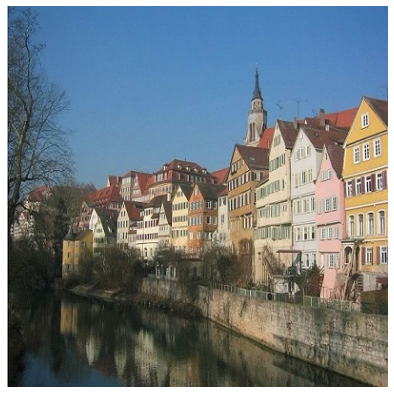

In [12]:
plt.figure(figsize=(15,7))
plt.imshow(content_copy)
plt.axis("off")

(-0.5, 399.5, 399.5, -0.5)

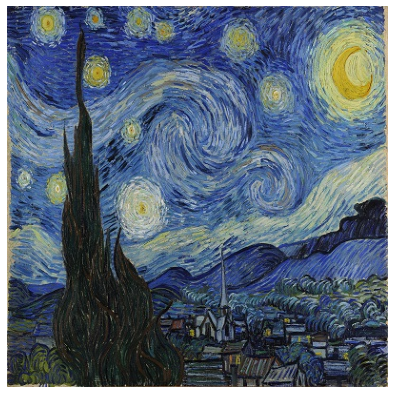

In [13]:
plt.figure(figsize=(15,7))

plt.imshow(style)
plt.axis("off")

In [14]:
# Define a function for style transfer (you need to implement this function)
def color_transfer(content, style, imsize):

        # Initialize variables
    C0 = content.reshape(-1)
    S0 = style.reshape(-1)

    # One-dimensional image
    h0 = imsize
    w0 = imsize

    # number of color channels
    c = 3

    # Convert to 3D arrays
    C0 = C0.reshape(h0, w0, c)
    S0 = S0.reshape(h0, w0, c)

    # Initialize C to color palette of S using histogram matching
    for channel in range(c):
        C0[:, :, channel] = exposure.match_histograms(C0[:, :, channel], S0[:, :, channel])

    C0 = cv2.GaussianBlur(C0, (5, 5), 0)
    # Reshape C0 to a 1D array
    C0 = C0.reshape(-1)

    X = C0
    X = X + np.max(X) * np.random.randn(X.size)  # Add large noise at the beginning
    X = X.reshape(h0, w0, c)
    return X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


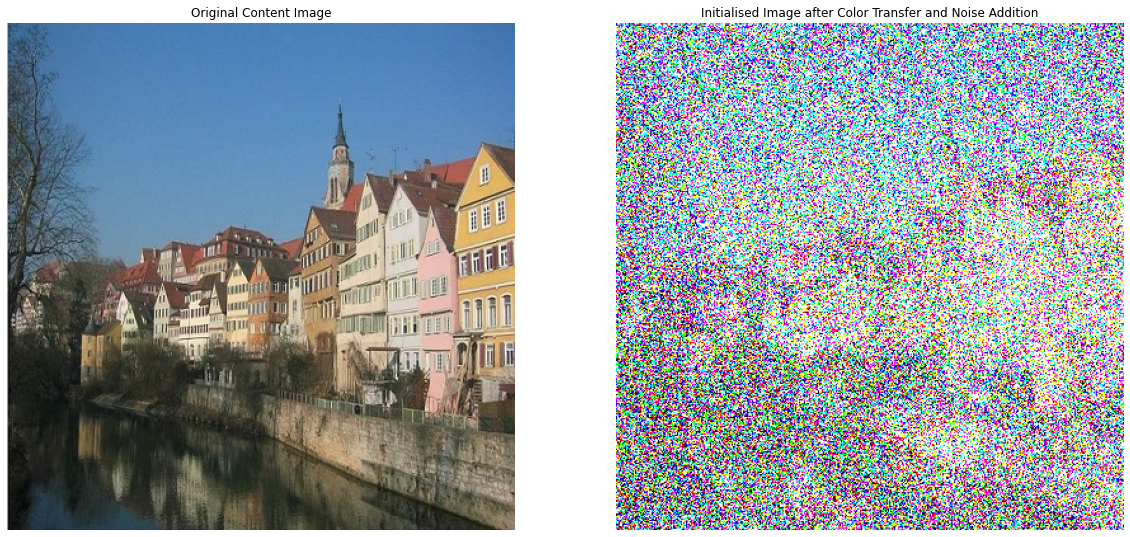

In [15]:
initialised_image = color_transfer(content, style, imsize)
# PLT THIS IMAGE

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Content Image")
plt.imshow(content_copy)

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Initialised Image after Color Transfer and Noise Addition") 
plt.imshow(initialised_image)

In [16]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

import math 

def nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap):
    opt = 1
    S = S.reshape((h, w, c))
    RX = X[R.astype(bool)]
    min_l2 = np.inf

    if opt == 0:
        P = Pp
        temp = np.tile(RX, (P.shape[1], 1)).T
        sqr = np.sum((temp - P) ** 2, axis=0)
        idx = np.argmin(sqr)
        ks, ls = np.unravel_index(idx, ((w - Q_size + 1), (h - Q_size + 1)))
        ks += 1  # Adjusting for 1-based indexing in MATLAB

    elif opt == 1:
        RXp = np.dot(Vp.T, (RX - mp))
        dif = np.tile(RXp, (1, Pp.shape[1])) - Pp
        sqr = np.sum(dif ** 2, axis=0)
        sqr += 0.1 * np.min(sqr) * np.random.randn(len(sqr))  # Adding some noise to NN
        idx = np.argmin(sqr)
        ls, ks = np.unravel_index(idx, (math.floor(((w - Q_size + 1) - 1) / Pstride) + 1,
                                        math.floor(((h - Q_size + 1) - 1) / Pstride) + 1))
        ks = (ks - 1) * Pstride + 1
        ls = (ls - 1) * Pstride + 1
        ang = (idx + 3) % 4  # Adding 3 to match ang = 90 * (0:3)

    elif opt == 2:
        raise NotImplementedError("Option 2 is not implemented in the Python conversion.")
        # htm = vision.TemplateMatcher('Metric', 'Sum of squared differences');
        # Loc = step(htm, rgb2gray(S), rgb2gray(reshape(RX, [Q_size Q_size 3])));
        # ks = int(np.floor(Loc[2] - Q_size / 2))
        # ls = int(np.floor(Loc[1] - Q_size / 2))

    z = S[ks:ks+Q_size, ls:ls+Q_size, :].flatten()

    return ks, ls, z


In [31]:
def irls(R, X, z):
    tNc, Nij = R.shape
    I = 5  # max number of IRLS iterations
    Xk = X.copy()  # current estimate
    r = 0.8
    unsampled_pixs = np.double(~(np.sum(R, axis=1) > 0))  # prevent black bar artifacts from gaps
    for k in range(I):
        A = unsampled_pixs  # prevent black bar artifacts from gaps
        B = Xk * unsampled_pixs
        for i in range(Nij):
            w = np.sum((Xk[R[:, i].astype(bool)] - z[:, i]) * 2 + 1e-10) * ((r - 2) / 2)
            A = A + w * R[:, i]
            temp = R[:, i].copy()
            temp[R[:, i].astype(bool)] = z[:, i]
            B = B + w * temp
        Xk = (1.0 / (A + 1e-10)) * B
    Xtilde = Xk
    return Xtilde

In [18]:
scales=[4,2,1]
patch_sizes=[36,22]
import math

h0=imsize
w0=imsize

c=3

hall = np.ones((400, 400,3))
mask0= np.ones((400, 400))

for L in scales:

    C_scaled = cv2.resize(np.reshape(content_copy, (h0, w0, c)), None, fx=1/L, fy=1/L)
    S_scaled = cv2.resize(np.reshape(style, (h0, w0, c)), None, fx=1/L, fy=1/L)

    mask = cv2.resize(mask0, None, fx=1/L, fy=1/L)

    C = C_scaled.flatten() 
    S = S_scaled.flatten()

    h = math.ceil(h0/L)
    w = math.ceil(w0/L)

    X = cv2.resize(np.reshape(initialised_image, (h0, w0, c)), (w, h))
    
    halls = cv2.resize(hall, (w, h))

    X = X.flatten()

    for n in patch_sizes:

        if L > 1 and n == 13:
            continue
        Q_size = n
        # Precompute P
        Pstride = 4
        S = S.reshape((h, w, c))
        P = np.zeros((c * Q_size * Q_size, (int(((h - Q_size + 1) - 1) / Pstride) + 1) * (int(((w - Q_size + 1) - 1) / Pstride) + 1) * 4))

        for k in range(0, h - Q_size + 1, Pstride):
            for j in range(0, w - Q_size + 1, Pstride):
                patch = S[k:k + Q_size, j:j + Q_size, :]
                for l in range(4):
                    temp = rotate(patch, l * 90, reshape=False, mode='reflect', order=1)
                    P[:, (int(k / Pstride) - 1) * (int((w - Q_size + 1 - 1) / Pstride) + 1) * 4 + (int(j / Pstride) - 1) * 4 + l + 1] = temp.flatten()

        S = S.flatten()
        # Remove mean from P
        mp = np.mean(P, axis=1)
        P = P - np.tile(mp[:, np.newaxis], (1, P.shape[1]))



        # Compute PCA of P
        PPT = np.dot(P, P.T)
        D, V = eigh(PPT)
        D = np.flip(D)
        V = np.flip(V, axis=1)

        # Find top eig values
        eig_idx = 1  # You can change this value if needed
        energy = 0
        energy_tot = np.sum(D)
        for i in range(D.shape[0]):
            energy += D[i]
            if energy >= 0.95 * energy_tot:
                eig_idx = i
                break

        # Reduce dimensionality
        Vp = V[:, :eig_idx]
        Pp = np.dot(Vp.T, P)


        gap_sizes=[28, 18,  9, 6]

        hallcoeff = 0

        from scipy.ndimage import rotate


        # Iterate for k=1, ..., Ialg

        for k in range(3):
        # 1. Style Fusion
             X = hallcoeff * halls.flatten() + (1 - hallcoeff) * X
        
        # # 2. Patch Matching
        #      print('patch matching')
        #     #  gap = gap_sizes[patch_sizes == n][0]
        #     #  gap = gap_sizes[patch_sizes.index(n)]
        #      gap = next(gap for gap, size in zip(gap_sizes, patch_sizes) if size == n)
        
        #      Rall = np.zeros((h * w * c, (math.floor(((h - Q_size + 1) - 1) / gap) + 1) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1)))
        #      z = np.zeros((c * n**2, (math.floor(((h - Q_size + 1) - 1) / gap) + 1) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1)))

        #      for i in range(1, h - Q_size + 2, gap):
        #         for j in range(1, w - Q_size + 2, gap):
        #             R = np.zeros((h, w, c))
        #             R[i:i+Q_size, j:j+Q_size, :] = 1
        #             R = R.flatten()
        #             idx = (math.ceil(i / gap) - 1) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1) + math.ceil(j / gap)
        #             Rall[:, idx] = R
        #             ks, ls, zij, ang = nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap)
        #             temp = rotate(zij.reshape(n, n, c), ang * 90, reshape=False, mode='constant', cval=0.0)
        #             z[:, idx] = temp.flatten()

        # 3 style synthesis
        Xtilde = irls(Rall, X, z)

        # 4. content fusion
        print('content fusion')
        W = (Wcoeff * mask.flatten() / np.max(mask))[:, np.newaxis]
        Xhat = (1 / (W + np.ones_like(W))) * (Xtilde + W * C)

        #5 color transfer
        print('color transfer')

        # Reshape Xhat and S to have shape (h, w, c)
        Xhat_reshaped = Xhat.reshape((h, w, c))
        S_reshaped = S.reshape((h, w, c))

        # Initialize an empty result array
        X = np.zeros((h * w, c))

        # Match histograms of each channel
        for channel in range(c):
            X[:, channel] = exposure.match_histograms(Xhat_reshaped[:, :, channel], S_reshaped[:, :, channel])

        # Reshape the result back to (h, w, c)
        X = X.reshape((h, w, c))
        